In [40]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import InMemorySaver 
from langchain_community.document_loaders import PyPDFLoader
from langgraph.prebuilt import ToolNode, tools_condition


In [41]:
import os


load_dotenv()

OLLAMA_HOST = os.getenv("OLLAMA_HOST")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL")
model = ChatOllama(
        model=OLLAMA_MODEL,
        base_url=OLLAMA_HOST,
        temperature=0.2,        # critical for factual stability
        # num_predict=800,        # max tokens to generate
        timeout=60              # avoid hanging workers
    )


In [42]:
loader = PyPDFLoader("/home/pradumansingh/Desktop/Agentic/intro-to-ml.pdf")
docs = loader.load()

In [43]:
len(docs)

392

In [44]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = splitter.split_documents(docs)
len(texts)

973

In [45]:
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
EMBED_MODEL = "qwen3-embedding:latest"

ollama_embedder = OllamaEmbeddings(
    model=EMBED_MODEL)

vectorstore = FAISS.from_documents(texts, ollama_embedder)

In [46]:
vectorstore

In [47]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k":4})

In [78]:
from langchain_core.tools import tool
@tool
def rag_tool(query: str) -> str:
    """
    Retrieve relevant information from the pdf document.
    """
    result = retriever.invoke(query)

    context = "\n\n".join(
        f"[Page {doc.metadata.get('page', 'N/A')}]\n{doc.page_content}"
        for doc in result
    )

    return context


In [79]:
tools = [rag_tool]
tool_node = ToolNode(tools)
llm_with_tools = model.bind(tools=tools)

In [87]:
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage

class InputType(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


In [88]:
from langchain_core.messages import BaseMessage, SystemMessage
def chat_node(state: InputType, config=None):
    """LLM node that may answer or request a tool call."""
    thread_id = None
    if config and isinstance(config, dict):
        thread_id = config.get("configurable", {}).get("thread_id")

    system_message = SystemMessage(
        content=(
            "You are a helpful assistant. For questions about the uploaded PDF, call "
            "the `rag_tool` and include the thread_id "
            f"`{thread_id}`. You can also use the web search, stock price, and "
            "calculator tools when helpful. If no document is available, ask the user "
            "to upload a PDF."
        )
    )

    messages = [system_message, *state["messages"]]
    response = llm_with_tools.invoke(messages, config=config)
    return {"messages": [response]}



In [82]:
tool_node = ToolNode(tools)

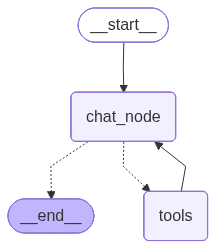

In [89]:
checkpointer = InMemorySaver()
graph = StateGraph(InputType)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges("chat_node", tools_condition)


graph.add_edge('tools', 'chat_node')

chatbot = graph.compile(checkpointer=checkpointer)
chatbot

In [90]:
from langchain_core.messages import HumanMessage

thread_id = "1"

while True:
    user_input = input("You: ")
    if user_input.lower() in {"exit", "quit"}:
        break

    result = chatbot.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    print("Bot:", result["messages"][-1].content)


ValidationError: 1 validation error for Tool
  Input should be a valid dictionary or instance of Tool [type=model_type, input_value=StructuredTool(name='rag_...tool at 0x7daf25637ba0>), input_type=StructuredTool]
    For further information visit https://errors.pydantic.dev/2.12/v/model_type